<a href="https://colab.research.google.com/github/taegukang35/graphcut_segmentation/blob/main/graphcut_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Image & Object and Background seed

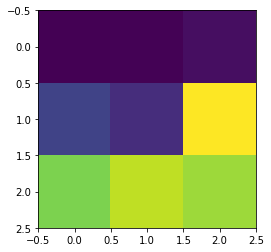

In [ ]:
import numpy as np
from math import exp, pow
import matplotlib.pyplot as plt

img = np.array([[12, 13, 17],
       [40, 30, 150],
       [123, 137, 130]])

plt.imshow(img)

In [ ]:
bkg = [(0,0),(1,0)]
obj = [(2,1),(2,2)]
bkg_values = [img[i[0]][i[1]] for i in bkg]
obj_values = [img[i[0]][i[1]] for i in obj]
hkg_hist,_= np.histogram(bkg_values,256,[0,256])
obj_hist,_= np.histogram(obj_values,256,[0,256])
print(obj_hist)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Cost function

Boundary Cost

In [ ]:
def B(p,q):
    return 100*exp(-pow(int(p)-int(q),2)/(2*pow(30,2)))

In [ ]:
B(180,200)

80.0737402916808

Gaussian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture
import cv2

data = bkg_values+obj_values
print(data)
gmm = GaussianMixture(n_components = 2)
gmm = gmm.fit(X=np.expand_dims(data,1))
gmm_x = np.linspace(0,253,256)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

[12, 40, 137, 130]


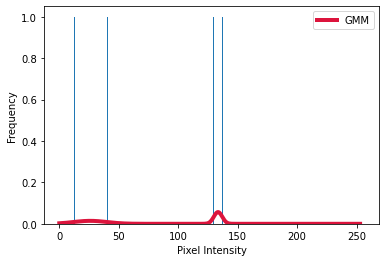

In [ ]:
fig, ax = plt.subplots()
ax.hist(data,255,[2,256])
ax.set_ylabel("Frequency")
ax.set_xlabel("Pixel Intensity")
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")
plt.legend()

plt.show()

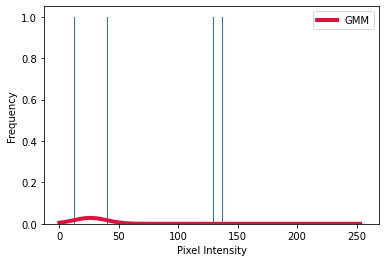

In [ ]:
bkg_gmm = GaussianMixture(n_components = 1)
bkg_gmm = bkg_gmm.fit(X=np.expand_dims(bkg_values,1))
gmm_x = np.linspace(0,253,256)
gmm_y = np.exp(bkg_gmm.score_samples(gmm_x.reshape(-1,1)))

fig, ax = plt.subplots()
ax.hist(data,255,[2,256])
ax.set_ylabel("Frequency")
ax.set_xlabel("Pixel Intensity")
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")
plt.legend()

plt.show()

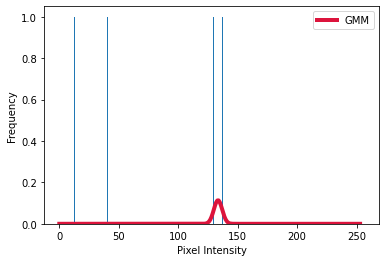

In [ ]:
obj_gmm = GaussianMixture(n_components = 1)
obj_gmm = obj_gmm.fit(X=np.expand_dims(obj_values,1))
gmm_x = np.linspace(0,253,256)
gmm_y = np.exp(obj_gmm.score_samples(gmm_x.reshape(-1,1)))

fig, ax = plt.subplots()
ax.hist(data,255,[2,256])
ax.set_ylabel("Frequency")
ax.set_xlabel("Pixel Intensity")
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")
plt.legend()

plt.show()

In [ ]:
np.exp(gmm.score_samples([[100]]))

array([1.221586e-08])

Regional Cost

In [ ]:
def R(p):
    p_obj = np.exp(obj_gmm.score_samples([[p]]))
    p_bkg = np.exp(bkg_gmm.score_samples([[p]]))
    return -np.log(p_obj),-np.log(p_bkg)

In [ ]:
R(100)

(array([47.97782025]), array([17.52738355]))

# Create Graph

In [ ]:
r,c = img.shape
V = r*c+2
G = np.zeros((V,V))
F = np.zeros((V,V))
alpha = 1
K = 1e9

Add node to graph & set cost of terminal edges 

In [ ]:
for i in range(r):
    for j in range(c):
        print(R(img[i][j]))
        if (i,j) in obj:
            G[0][1+c*i+j] = K
            G[1+c*i+j][V-1] = 0
        elif (i,j) in bkg:
            G[0][1+c*i+j] = 0
            G[1+c*i+j][V-1] = K
        else:
            R_bkg, R_obj = R(img[i][j])
            G[0][1+c*i+j] = alpha*R_obj
            G[1+c*i+j][V-1] = alpha*R_bkg

(array([604.71246868]), array([4.05799586]))
(array([594.83491847]), array([3.98911831]))
(array([556.14104408]), array([3.76462852]))
(array([358.99820303]), array([4.05799586]))
(array([439.40635973]), array([3.59881219]))
(array([13.28394553]), array([42.78248546]))
(array([6.67170118]), array([27.56054676]))
(array([2.6717015]), array([34.98911815]))
(array([2.6717015]), array([31.14983246]))


Set cost of adjacent pixels

In [ ]:
for i in range(r):
    for j in range(c):
        if i-1>=0 and G[c*i+j+1][c*(i-1)+j+1]==0:
            G[c*i+j+1][c*(i-1)+j+1] = B(img[i][j],img[i-1][j])
            G[c*(i-1)+j+1][c*i+j+1] = B(img[i][j],img[i-1][j])
        if i+1<r and G[c*i+j+1][c*(i+1)+j+1]==0:
            G[c*i+j+1][c*(i+1)+j+1] = B(img[i][j],img[i+1][j])
            G[c*(i+1)+j+1][c*i+j+1] = B(img[i][j],img[i+1][j])
        if j-1>=0 and G[c*i+j+1][c*i+(j-1)+1]==0:
            G[c*i+j+1][c*i+(j-1)+1] = B(img[i][j],img[i][j-1])
            G[c*i+(j-1)+1][c*i+j+1] = B(img[i][j],img[i][j-1])
        if j+1<c and G[c*i+(j+1)+1][c*i+(j+1)+1]==0:
            G[c*i+j+1][c*i+(j+1)+1] = B(img[i][j+1],img[i][j])
            G[c*i+(j+1)+1][c*i+j+1] = B(img[i][j+1],img[i][j])


#Minimum Cut

Max flow via ford-fulkerson

In [ ]:
from collections import deque

def networkFlow(source, sink, capacity, flow):
    N, totalflow = len(capacity), 0
    while True:
        # BFS 로 경로 탐색
        parent = [-1]*N
        queue = deque()
        parent[source] = source
        queue.append(source)
        while queue and parent[sink] == -1:
            p = queue.popleft()
            for q in range(N):
                # 잔여 용량이 남아있는 간선 탐색
                if capacity[p][q]-flow[p][q] > 0 and parent[q] == -1:
                    queue.append(q)
                    parent[q] = p
        # 증가 가능 경로가 없으면 종료
        if parent[sink] == -1: break
        # 증가 경로를 통해 얼마나 보낼지 결정
        p, amount = sink,int(1e9)
        while (p != source):
            amount = min(amount, capacity[parent[p]][p]-flow[parent[p]][p])
            p = parent[p]
        # 증가 경로로 유량을 보냄
        p = sink
        while (p != source):
            flow[parent[p]][p] += amount
            flow[p][parent[p]] -= amount
            p = parent[p]
        totalflow += amount
    return totalflow 

minimum-cut edge

In [ ]:
capacity = [[0, 16, 13, 0, 0, 0],
        [0, 0, 10, 12, 0, 0],
        [0, 4, 0, 0, 14, 0],
        [0, 0, 9, 0, 0, 20],
        [0, 0, 0, 7, 0, 4],
        [0, 0, 0, 0, 0, 0]]
flow = [[0]*6 for _ in range(6)]
source = 0; sink = 5
print(networkFlow(0,5, capacity, flow))

def dfs(graph,s,visited):
        visited[s]=True
        for i in range(len(graph)):
            if graph[s][i]>0 and not visited[i]:
                dfs(graph,i,visited)
visited = [False]*6
dfs(capacity,0,visited)

23


In [ ]:
for i in range(6):
    for j in range(6):
        if visited[i] and capacity[i][j]==flow[i][j]!=0:
            print(i,j)
            capacity[i][j] = 0

In [ ]:
group = [False]*6
dfs(capacity,0,group)
print(group)

[True, True, True, False, True, False]


#Image Segmentation via Graph-cut

In [ ]:
networkFlow(0,V-1,G,F)

2.3887835252008327

In [ ]:
visited = [False]*V
dfs(G,0,visited)
for i in range(V):
    for j in range(V):
        if visited[i] and G[i][j]==F[i][j]!=0:
            print(i,j)
            G[i][j] = 0
group = [False]*V
dfs(G,0,group)
print(group)

6 3
6 5
6 10
7 4
7 10
8 5
[True, False, False, False, False, False, True, True, True, True, False]


In [ ]:
r,c = img.shape
mask = np.zeros((r,c))
for i in range(r):
    for j in range(c):
        if group[1+i*c+j]:
            mask[i][j] = 1
print(mask)

[[0. 0. 0.]
 [0. 0. 1.]
 [1. 1. 1.]]


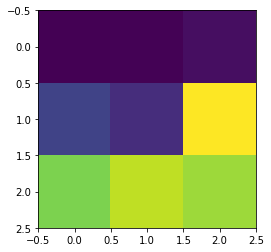

In [ ]:
plt.imshow(img)

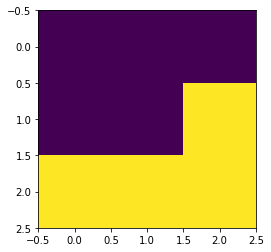

In [ ]:
plt.imshow(mask)

#Make Graphcut Segmentation Module

In [ ]:
import numpy as np
from math import exp, pow
from sklearn.mixture import GaussianMixture
from collections import deque
import matplotlib.pyplot as plt



class Segmentation:
    def __init__(self, img: np.ndarray, objLabel, bkgLabel,alpha):
        self.img = img
        self.bkg = bkgLabel
        self.obj = objLabel
        self.alpha = alpha

    def B(self, p, q):
        return 100 * exp(-pow(int(p) - int(q), 2) / (2 * pow(30, 2)))

    def get_gmm(self):
        bkg_values = [self.img[i[0]][i[1]] for i in self.bkg]
        obj_values = [self.img[i[0]][i[1]] for i in self.obj]
        hkg_hist, _ = np.histogram(bkg_values, 256, [0, 256])
        obj_hist, _ = np.histogram(obj_values, 256, [0, 256])

        obj_gmm = GaussianMixture(n_components=1)
        obj_gmm = obj_gmm.fit(X=np.expand_dims(obj_values, 1))
        bkg_gmm = GaussianMixture(n_components=1)
        bkg_gmm = bkg_gmm.fit(X=np.expand_dims(bkg_values, 1))
        return obj_gmm, bkg_gmm

    def R(self, p, obj_gmm, bkg_gmm):
        p_obj = np.exp(obj_gmm.score_samples([[p]]))
        p_bkg = np.exp(bkg_gmm.score_samples([[p]]))
        p_p_obj = p_obj / (p_obj + p_bkg)
        p_p_bkg = p_bkg / (p_obj + p_bkg)
        return -np.log(p_p_obj), -np.log(p_p_bkg)

    # Image to Graph
    def make_graph(self):
        r, c = self.img.shape
        V = r * c + 2
        G = np.zeros((V,V))
        K = 1e9

        # Regional Cost
        obj_gmm, bkg_gmm = self.get_gmm()
        for i in range(r):
            for j in range(c):
                if (i, j) in self.obj:
                    G[0][1 + c * i + j] = K
                    G[1 + c * i + j][V - 1] = 0
                elif (i, j) in self.bkg:
                    G[0][1 + c * i + j] = 0
                    G[1 + c * i + j][V - 1] = K
                else:
                    R_bkg, R_obj = self.R(self.img[i][j], obj_gmm, bkg_gmm)
                    G[0][1 + c * i + j] = self.alpha * R_obj
                    G[1 + c * i + j][V - 1] = self.alpha * R_bkg

        # Boundary Cost
        for i in range(r):
            for j in range(c):
                if i - 1 >= 0 and G[c * i + j + 1][c * (i - 1) + j + 1] == 0:
                    G[c * i + j + 1][c * (i - 1) + j + 1] = self.B(self.img[i][j], self.img[i - 1][j])
                    G[c * (i - 1) + j + 1][c * i + j + 1] = self.B(self.img[i][j], self.img[i - 1][j])
                if i + 1 < r and G[c * i + j + 1][c * (i + 1) + j + 1] == 0:
                    G[c * i + j + 1][c * (i + 1) + j + 1] = self.B(self.img[i][j], self.img[i + 1][j])
                    G[c * (i + 1) + j + 1][c * i + j + 1] = self.B(self.img[i][j], self.img[i + 1][j])
                if j - 1 >= 0 and G[c * i + j + 1][c * i + (j - 1) + 1] == 0:
                    G[c * i + j + 1][c * i + (j - 1) + 1] = self.B(self.img[i][j], self.img[i][j - 1])
                    G[c * i + (j - 1) + 1][c * i + j + 1] = self.B(self.img[i][j], self.img[i][j - 1])
                if j + 1 < c and G[c * i + (j + 1) + 1][c * i + (j + 1) + 1] == 0:
                    G[c * i + j + 1][c * i + (j + 1) + 1] = self.B(self.img[i][j + 1], self.img[i][j])
                    G[c * i + (j + 1) + 1][c * i + j + 1] = self.B(self.img[i][j + 1], self.img[i][j])
        return G

    def networkFlow(self, source, sink, capacity, flow):
        N, totalflow = len(capacity), 0
        while True:
            parent = [-1] * N
            queue = deque()
            parent[source] = source
            queue.append(source)
            while queue and parent[sink] == -1:
                p = queue.popleft()
                for q in range(N):
                    if capacity[p][q] - flow[p][q] > 0 and parent[q] == -1:
                        queue.append(q)
                        parent[q] = p
            if parent[sink] == -1: break
            p, amount = sink, int(1e9)
            while (p != source):
                amount = min(amount, capacity[parent[p]][p] - flow[parent[p]][p])
                p = parent[p]
            p = sink
            while (p != source):
                flow[parent[p]][p] += amount
                flow[p][parent[p]] -= amount
                p = parent[p]
            totalflow += amount
        return totalflow

    def run(self):
        r, c = self.img.shape
        V = r * c + 2
        G = self.make_graph()
        F = np.zeros((V, V))
        self.networkFlow(0, V - 1, G, F)

        def dfs(graph, s, visited):
            visited[s] = True
            for i in range(len(graph)):
                if graph[s][i] > 0 and not visited[i]:
                    dfs(graph, i, visited)

        visited = [False] * V
        dfs(G, 0, visited)
        for i in range(V):
            for j in range(V):
                if visited[i] and G[i][j] == F[i][j] != 0:
                    G[i][j] = 0
        group = [False] * V
        dfs(G, 0, group)
        mask = np.zeros((r, c))
        for i in range(r):
            for j in range(c):
                if group[1 + i * c + j]:
                    mask[i][j] = 1
        return mask

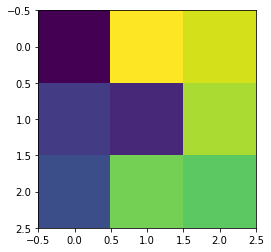

In [ ]:
img = np.array([[12, 170, 160],
       [40, 30, 150],
       [50, 137, 130]])
bkg = [(0,0),(1,0)]
obj = [(2,1),(2,2)]
S = Segmentation(img,obj,bkg,1)
mask = S.run()
plt.imshow(img)

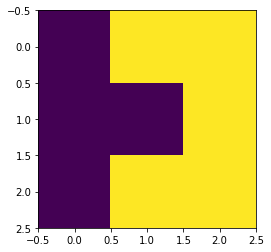

In [ ]:
plt.imshow(mask)

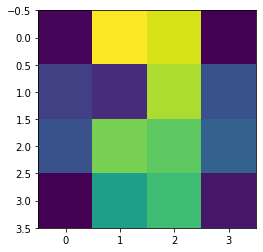

In [ ]:
img = np.array([[12, 170, 160,10],
       [40, 30, 150,50],
       [50, 137, 130,60],
       [10,100,120,20]])
bkg = [(0,0),(1,0)]
obj = [(2,1),(2,2)]
S = Segmentation(img,obj,bkg,1)
mask = S.run()
plt.imshow(img)

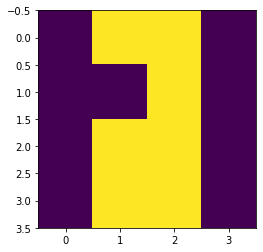

In [ ]:
plt.imshow(mask)

dataset: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/train-001-025.html

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning:

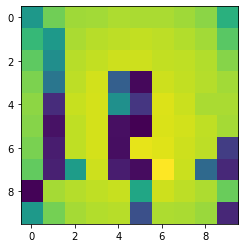

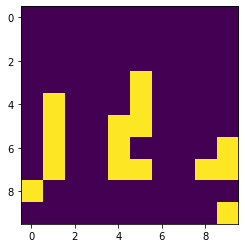

In [ ]:
img = cv2.imread('42049.jpg',0)
nimg = cv2.resize(img, (10, 10))
obj = [(5,4),(6,4)]
bkg = [(1,i) for i in range(2,8)]

S = Segmentation(nimg,obj,bkg,0.1)
mask = S.run()
plt.imshow(nimg)
plt.show()
plt.imshow(mask)

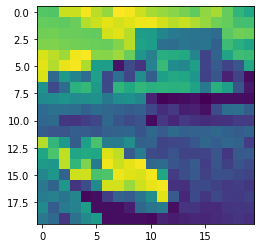

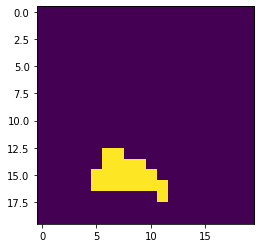

In [ ]:
import cv2
img = cv2.imread('/content/78004.jpg',0)
nimg = cv2.resize(img, (20, 20))
obj = [(15,i) for i in range(5,10)]
bkg = [(i,3) for i in range(8,11)]
#bkg = [(9,i) for i in range(1,10)]
S = Segmentation(nimg,obj,bkg,0.1)
mask = S.run()
plt.imshow(nimg)
plt.show()
plt.imshow(mask)

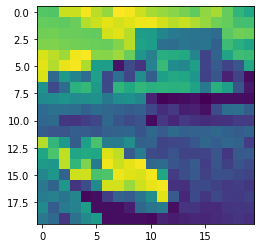

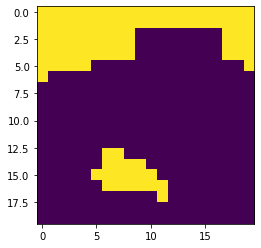

In [ ]:
S = Segmentation(nimg,obj,bkg,0.5)
mask = S.run()
plt.imshow(nimg)
plt.show()
plt.imshow(mask)

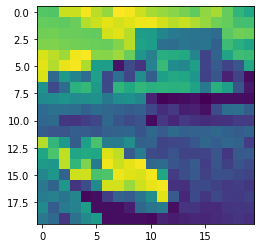

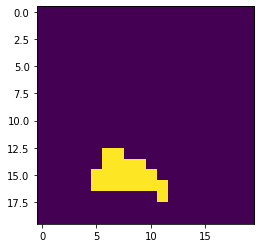

In [ ]:
S = Segmentation(nimg,obj,bkg,0.1)
mask = S.run()
plt.imshow(nimg)
plt.show()
plt.imshow(mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning:

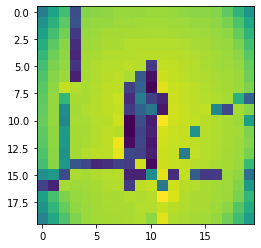

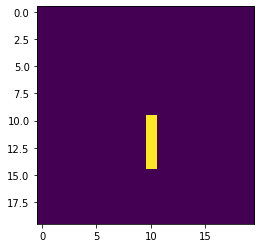

In [ ]:
img = cv2.imread('/content/42049.jpg',0)
nimg = cv2.resize(img, (20, 20))
obj = [(i,10) for i in range(10,14)]
bkg = [(5,i) for i in range(7,15)]
S = Segmentation(nimg,obj,bkg,1)
mask = S.run()
plt.imshow(nimg)
plt.show()
plt.imshow(mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning:

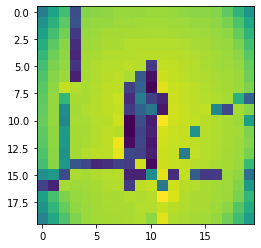

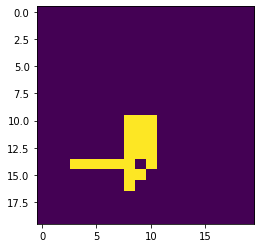

In [ ]:
img = cv2.imread('/content/42049.jpg',0)
nimg = cv2.resize(img, (20, 20))
obj = [(i,10) for i in range(10,14)]
bkg = [(5,i) for i in range(7,15)]
S = Segmentation(nimg,obj,bkg,0.1)
mask = S.run()
plt.imshow(nimg)
plt.show()
plt.imshow(mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning:

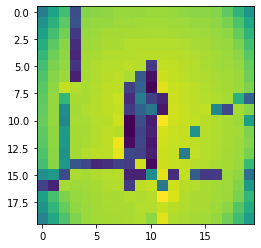

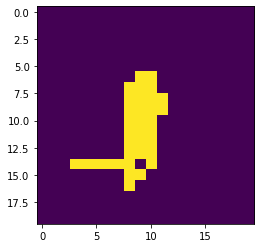

In [ ]:
S = Segmentation(nimg,obj,bkg,0.01)
mask = S.run()
plt.imshow(nimg)
plt.show()
plt.imshow(mask)

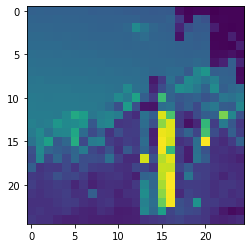

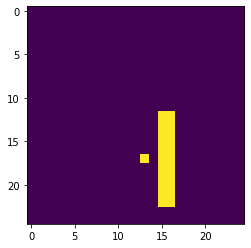

In [ ]:
img = cv2.imread('/content/126007.jpg',0)
nimg = cv2.resize(img, (25, 25))
obj = [(i,15) for i in range(15,20)]
bkg = [(i,5) for i in range(10,20)]
S = Segmentation(nimg,obj,bkg,0.1)
mask = S.run()
plt.imshow(nimg)
plt.show()
plt.imshow(mask)

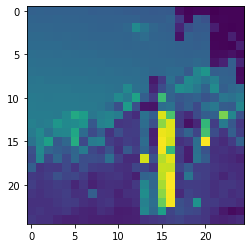

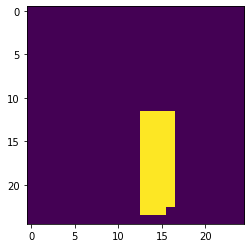

In [ ]:
S = Segmentation(nimg,obj,bkg,0.1)
mask = S.run()
obj = [(i,15) for i in range(15,20)]+[(i,13) for i in range(15,20)]
plt.imshow(nimg)
plt.show()
plt.imshow(mask)

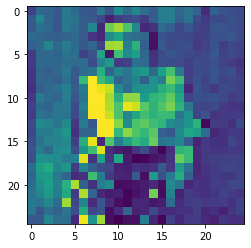

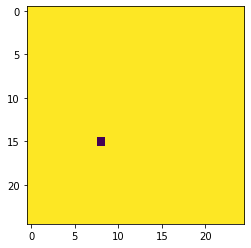

In [ ]:
img = cv2.imread('/content/181079.jpg',0)
nimg = cv2.resize(img, (25, 25))
obj = [(i,10) for i in range(3,20)]
bkg = [(i,3) for i in range(3,20)]+[(i,23) for i in range(3,20)]
S = Segmentation(nimg,obj,bkg,0.1)
mask = S.run()
obj = [(i,15) for i in range(15,20)]+[(i,13) for i in range(15,20)]
plt.imshow(nimg)
plt.show()
plt.imshow(mask)

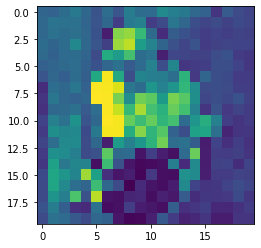

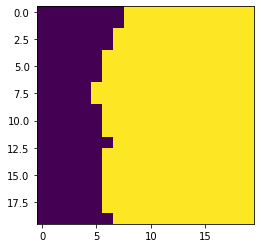

In [ ]:
img = cv2.imread('/content/181079.jpg',0)
nimg = cv2.resize(img, (20, 20))
obj = [(i,10) for i in range(3,20)]
bkg = [(i,3) for i in range(3,20)]
S = Segmentation(nimg,obj,bkg,0.1)
mask = S.run()
plt.imshow(nimg)
plt.show()
plt.imshow(mask)